# Discriminator Model Performance

This notebook is designed to analyze the discriminator model's performance. Once the generative model labels our data, the discriminator model takes those labels and improves on predictions. For this notebook we are using a generative model trained on Compound treats Disease label functions to predict Compound treats Disease sentences. Performance for each model is reported in area under the receiver operating curve (AUROC) and area under the precision recall curve (AUPR).

In [1]:
import glob
import os
import pandas as pd

import plotnine as p9
import scipy.stats as ss
from sklearn.metrics import auc, precision_recall_curve, roc_curve, precision_recall_fscore_support

# Tune Set

## Performance of Disc model vs Gen model for each Label Sample

In [2]:
dev_labels = pd.read_csv("input/ctd_dev_labels.tsv", sep="\t")
dev_labels.head()

,candidate_id,curated_ctd
0,65897,0.0
1,65932,0.0
2,66091,0.0
3,66144,0.0
4,66388,0.0


In [3]:
candidate_df = (
    pd.read_excel("../data/sentences/sentence_labels_dev.xlsx")
    .sort_values("candidate_id")
    .query("curated_ctd.notnull()")
)
candidate_df.head()

,candidate_id,compound,disease,drugbank_id,doid_id,sentence,curated_ctd,notes_ctd
0,65897,Imipramine,rheumatoid arthritis,DB00458,DOID:7148,"~~[[1 imipramine 1]]~~ , ~~[[2 rheumatoid arth...",0.0,NaN
1,65932,tryptophan,Multiple Sclerosis,DB00150,DOID:2377,this brief report develops the ideas of some p...,0.0,sounds like side effects
2,66091,indomethacin,hypertensives,DB00328,DOID:10763,"when compared to normals , essential ~~[[2 hyp...",0.0,NaN
3,66144,sulphasalazine,ulcerative colitis,DB00795,DOID:8577,patients with ~~[[2 ulcerative colitis 2]]~~ i...,0.0,NaN
4,66388,sulphasalazine,ulcerative colitis,DB00795,DOID:8577,"the absorption , metabolism and excretion of ~...",0.0,NaN


In [4]:
gen_model_results_dev_df = pd.read_csv(
    "../label_sampling_experiment/results/CtD/results/dev_sampled_results.tsv", 
    sep="\t"
)

In [5]:
disc_model_dict = {}

for value in gen_model_results_dev_df.lf_num.unique():
        
    disc_model_dict[value] = (
        pd.read_csv(f"input/disc_model_run/{value}/tune.tsv", sep="\t")
    )

In [6]:
def get_au_performance(predictions, gold_labels):
    fpr, tpr, _ = roc_curve(
        gold_labels,
        predictions
    )
    
    precision, recall, _ = precision_recall_curve(
        gold_labels,
        predictions
    )
    
    return auc(fpr, tpr), auc(recall, precision)

In [7]:
records = []
for sample in disc_model_dict:
        for column in disc_model_dict[sample].drop("candidate_id", axis=1).columns:
            aucs = get_au_performance(
                disc_model_dict[sample][column], 
                candidate_df
                .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
                .curated_ctd
                .values
            )
            records.append({
                "model": "disc_model",
                "lf_num": int(sample),
                "auroc": aucs[0],
                "aupr": aucs[1]
            })

dev_set_df = (
    pd.DataFrame.from_records(records)
    .append(
        gen_model_results_dev_df
        .drop("lf_sample", axis=1)
        .assign(model="gen_model")
    )
)

In [8]:
dev_set_stats_df = (
    dev_set_df
    .groupby(["lf_num", "model"])
    .agg({
    "auroc": ['mean', 'std'],
    "aupr": ['mean', 'std'],
    "lf_num": len
    })
    .reset_index()
    .fillna(0)
)
dev_set_stats_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in dev_set_stats_df.columns.values
]

critical_val = ss.norm.ppf(0.975)

dev_set_stats_df = (
    dev_set_stats_df
    .assign(
        **{
            'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_lower':lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
        }
    )
)
dev_set_stats_df

,lf_num,model,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,disc_model,0.719287,0.000000,0.331734,0.000000,1,0.719287,0.719287,0.331734,0.331734
1,0,gen_model,0.681995,0.000000,0.491901,0.000000,1,0.681995,0.681995,0.491901,0.491901
2,1,disc_model,0.726972,0.024005,0.359048,0.022986,50,0.733626,0.720318,0.365420,0.352677
3,1,gen_model,0.715703,0.041762,0.472581,0.059901,50,0.727279,0.704127,0.489185,0.455978
4,6,disc_model,0.779263,0.041241,0.442849,0.066110,50,0.790694,0.767831,0.461173,0.424524
5,6,gen_model,0.764198,0.047758,0.433273,0.068972,50,0.777435,0.750960,0.452390,0.414155
6,11,disc_model,0.821664,0.034093,0.521992,0.065250,50,0.831114,0.812214,0.540078,0.503906
7,11,gen_model,0.797896,0.036104,0.465717,0.074211,50,0.807903,0.787888,0.486287,0.445147
8,16,disc_model,0.852828,0.021023,0.590318,0.052030,50,0.858656,0.847001,0.604740,0.575896
9,16,gen_model,0.821603,0.024551,0.484469,0.044543,50,0.828408,0.814798,0.496815,0.472122


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


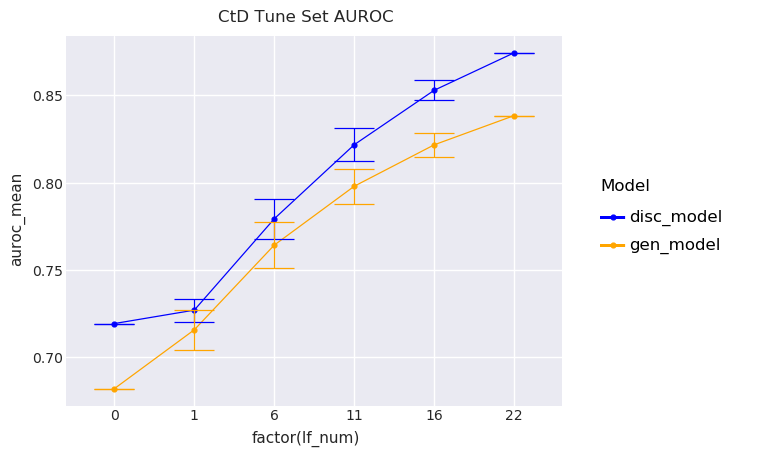

<ggplot: (8746347330575)>

In [9]:
(
    p9.ggplot(dev_set_stats_df, p9.aes(x="factor(lf_num)", y="auroc_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "CtD Tune Set AUROC",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


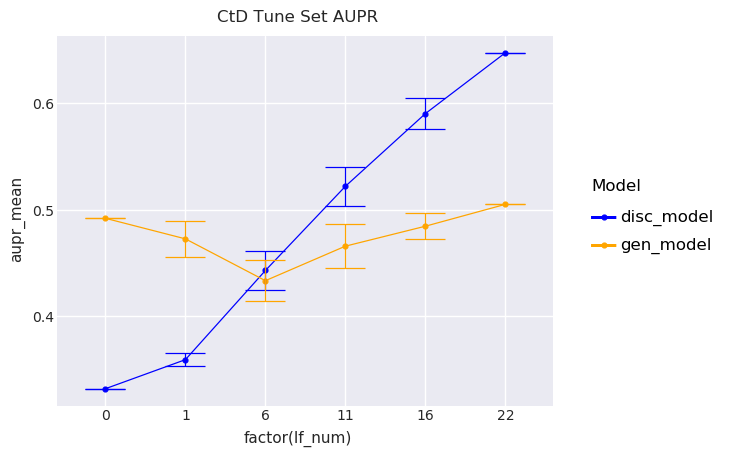

<ggplot: (8746347302948)>

In [10]:
(
    p9.ggplot(dev_set_stats_df, p9.aes(x="factor(lf_num)", y="aupr_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "CtD Tune Set AUPR",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
)

In [11]:
dev_set_df.to_csv("output/dev_set_disc_performance.tsv", sep="\t", index=False)

##  Precision-Recall Improvement over Generative Model

In [12]:
gen_predicton = (
    pd.read_csv(
        "../label_sampling_experiment/results/CtD/marginals/tune/22_sampled_dev.tsv",
        sep="\t"
    )
    .assign(candidate_id=candidate_df.candidate_id.values.tolist())
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .iloc[:,0]
)

In [13]:
disc_precision, disc_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_ctd
    .values, 
    disc_model_dict[22]['0']
)

gen_precision, gen_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_ctd
    .values,
    gen_predicton
)

In [14]:
pr_perform_df = (
    pd.DataFrame(
        {'precision':gen_precision, 'recall':gen_recall}
    )
    .assign(model='gen_model')
    .append(
        pd.DataFrame(
            {'precision':disc_precision, 'recall':disc_recall}
        )
        .assign(model='disc_model')
    )
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


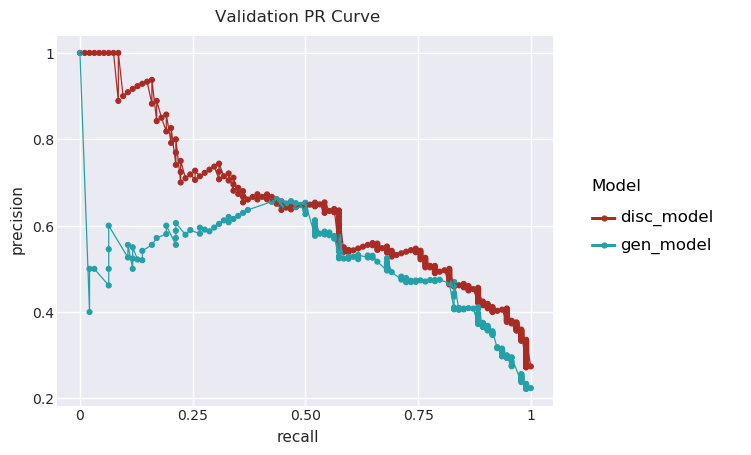

<ggplot: (8746345012579)>

In [15]:
(
    p9.ggplot(pr_perform_df, p9.aes(x="recall", y="precision", color="factor(model)")) +
    p9.geom_point()+ 
    p9.geom_line() + 
    p9.labs(
        title= "Validation PR Curve",
        color="Model"
    )+
    p9.scale_color_discrete(l=.4)+
    p9.theme_seaborn()
)

In [16]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_ctd
    .values, 
    gen_predicton.apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.4068627450980392, 0.8829787234042553, 0.5570469798657718, None)

In [17]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_ctd
    .values, 
    disc_model_dict[22]['0'].apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.5298507462686567, 0.7553191489361702, 0.6228070175438597, None)

In [18]:
pr_perform_df.to_csv("output/dev_set_pr_performance.tsv", sep="\t", index=False)

# Test Set

## Performance of Disc model vs Gen model for each Label Sample

In [19]:
test_labels = pd.read_csv("input/ctd_test_labels.tsv", sep="\t")
test_labels.head()

,candidate_id,curated_ctd
0,65876,0.0
1,66250,0.0
2,66695,0.0
3,66719,0.0
4,67814,0.0


In [20]:
candidate_df = (
    pd.read_excel("../data/sentences/sentence_labels_test.xlsx")
    .sort_values("candidate_id")
    .query("curated_ctd.notnull()")
)
candidate_df.head()

,candidate_id,compound,disease,drugbank_id,doid_id,sentence,curated_ctd,notes_ctd
0,65876,sucrose,mouse hepatitis virus,DB02772,DOID:2043,"the rna of ~~[[2 mouse hepatitis virus 2]]~~ ,...",0.0,NaN
1,66250,phenylalanine,hepatoma,DB02556,DOID:3571,epigenetic activation of ~~[[1 phenylalanine 1...,0.0,NaN
2,66695,adenosine 5'-triphosphate,mastocytoma,DB00171,DOID:2531,"the effect of the antileukemia drug , 4 ' - ( ...",0.0,NaN
3,66719,phenylalanine,hepatoma,DB02556,DOID:3571,analysis by double immunodiffusion showed that...,0.0,NaN
4,67814,phenylalanine,hepatoma,DB02556,DOID:3571,naturally-occurring and synthetic analogues of...,0.0,NaN


In [21]:
gen_model_results_test_df = pd.read_csv(
    "../label_sampling_experiment/results/CtD/results/test_sampled_results.tsv", 
    sep="\t"
)

In [22]:
disc_model_dict = {}

for value in gen_model_results_test_df.lf_num.unique():

    disc_model_dict[value] = (
        pd.read_csv(f"input/disc_model_run/{value}/test.tsv", sep="\t")
    )

In [23]:
records = []
for sample in disc_model_dict:
        for column in disc_model_dict[sample].drop("candidate_id", axis=1).columns:
            aucs = get_au_performance(
                disc_model_dict[sample][column], 
                candidate_df
                .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
                .curated_ctd
                .values
            )
            records.append({
                "model": "disc_model",
                "lf_num": int(sample),
                "auroc": aucs[0],
                "aupr": aucs[1]
            })

test_set_df = (
    pd.DataFrame.from_records(records)
    .append(
        gen_model_results_test_df
        .drop("lf_sample", axis=1)
        .assign(model="gen_model")
    )
)

In [24]:
test_set_stats_df = (
    test_set_df
    .groupby(["lf_num", "model"])
    .agg({
    "auroc": ['mean', 'std'],
    "aupr": ['mean', 'std'],
    "lf_num": len
    })
    .reset_index()
    .fillna(0)
)
test_set_stats_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in test_set_stats_df.columns.values
]

critical_val = ss.norm.ppf(0.975)

test_set_stats_df = (
    test_set_stats_df
    .assign(
        **{
            'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_lower':lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
        }
    )
)
test_set_stats_df

,lf_num,model,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,disc_model,0.719883,0.000000,0.402047,0.000000,1,0.719883,0.719883,0.402047,0.402047
1,0,gen_model,0.521712,0.000000,0.289713,0.000000,1,0.521712,0.521712,0.289713,0.289713
2,1,disc_model,0.716556,0.037368,0.390015,0.031176,50,0.726914,0.706198,0.398656,0.381373
3,1,gen_model,0.573961,0.046009,0.317025,0.042029,50,0.586714,0.561208,0.328675,0.305375
4,6,disc_model,0.747180,0.050095,0.446736,0.055768,50,0.761066,0.733295,0.462194,0.431278
5,6,gen_model,0.659184,0.057228,0.371175,0.053996,50,0.675047,0.643322,0.386142,0.356208
6,11,disc_model,0.766449,0.042373,0.501297,0.052608,50,0.778194,0.754704,0.515879,0.486715
7,11,gen_model,0.694896,0.043434,0.410273,0.052651,50,0.706935,0.682856,0.424866,0.395679
8,16,disc_model,0.782723,0.022177,0.534415,0.033761,50,0.788870,0.776576,0.543773,0.525057
9,16,gen_model,0.728845,0.021619,0.450136,0.031088,50,0.734837,0.722852,0.458753,0.441519


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


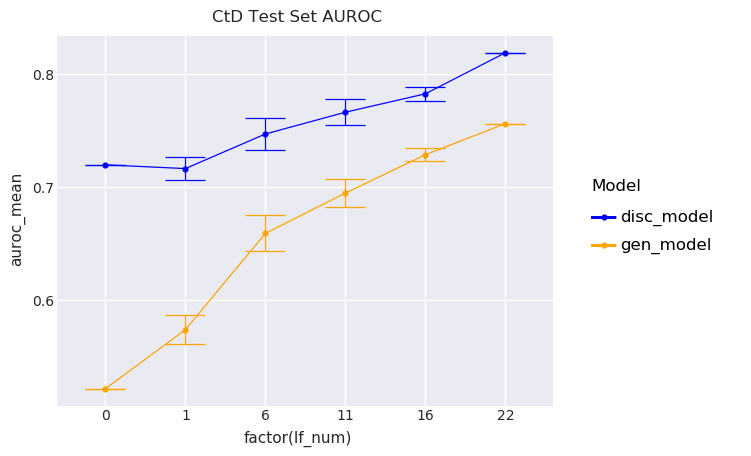

<ggplot: (-9223363290510001050)>

In [25]:
(
    p9.ggplot(test_set_stats_df, p9.aes(x="factor(lf_num)", y="auroc_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "CtD Test Set AUROC",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


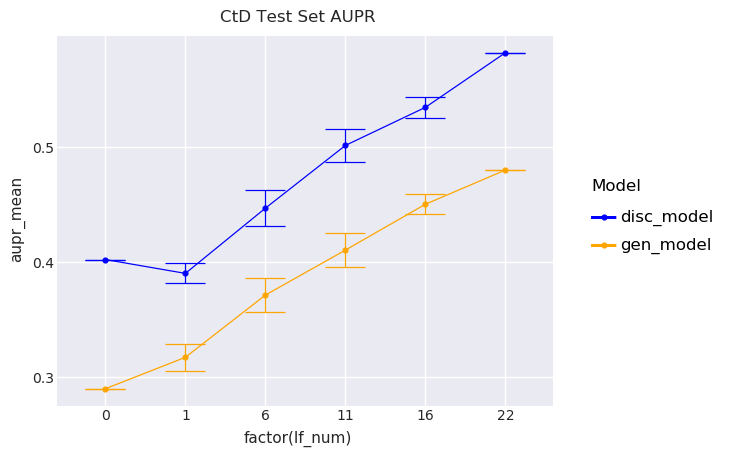

<ggplot: (-9223363290509900740)>

In [26]:
(
    p9.ggplot(test_set_stats_df, p9.aes(x="factor(lf_num)", y="aupr_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "CtD Test Set AUPR",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
)

In [27]:
test_set_df.to_csv("output/test_set_disc_performance.tsv", sep="\t", index=False)

##  Precision-Recall Improvement over Generative Model

In [28]:
gen_predicton = (
    pd.read_csv(
        "../label_sampling_experiment/results/CtD/marginals/test/22_sampled_test.tsv",
        sep="\t"
    )
    .assign(candidate_id=candidate_df.candidate_id.values.tolist())
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .iloc[:,0]
)

In [29]:
disc_precision, disc_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_ctd
    .values, 
    disc_model_dict[22]['0']
)

gen_precision, gen_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_ctd
    .values,
    gen_predicton
)

In [30]:
pr_perform_df = (
    pd.DataFrame(
        {'precision':gen_precision, 'recall':gen_recall}
    )
    .assign(model='gen_model')
    .append(
        pd.DataFrame(
            {'precision':disc_precision, 'recall':disc_recall}
        )
        .assign(model='disc_model')
    )
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


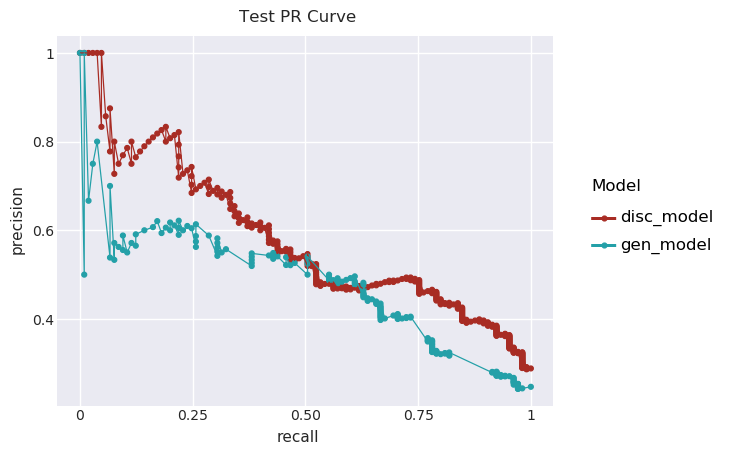

<ggplot: (8746347617579)>

In [31]:
(
    p9.ggplot(pr_perform_df, p9.aes(x="recall", y="precision", color="factor(model)")) +
    p9.geom_point()+ 
    p9.geom_line() + 
    p9.labs(
        title= "Test PR Curve",
        color="Model"
    )+
    p9.scale_color_discrete(l=.4)+
    p9.theme_seaborn()
)

In [32]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_ctd
    .values, 
    gen_predicton.apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.48120300751879697, 0.6095238095238096, 0.5378151260504201, None)

In [33]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_ctd
    .values, 
    disc_model_dict[22]['0'].apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.5866666666666667, 0.41904761904761906, 0.4888888888888889, None)

In [34]:
pr_perform_df.to_csv("output/test_set_pr_performance.tsv", sep="\t", index=False)